# Czas-częstość (*time-frequency*)
<img src='http://martinos.org/mne/dev/_images/sphx_glr_plot_sensors_time_frequency_005.png' width="45%" height="45%" />
Czas na wstęp do zagadnień analiz czas-częstość. Zanim jednak zanurkujemy w częstotliwości, zajmiemy się wczytywaniem plików. Ze względu na to że dane z prezentacją twarzy nie nadają się do analizy czas-częstość (zbyt krótki baseline i za dużo się w nim dzieje - o tym jeszcze będzie później) skorzystamy z innych danych - z zdania decyzyjnego. Najpierw zdefiniujemy gdzie są pliki, a później objaśnię nieco na czym polega zadanie.

In [15]:
import os
import os.path as op

data_dir = op.join(r'C:\Users\swps\Dropbox\CURRENT PROJECTS',
            r'mozg-rozpajton-2016-2017\DiamDec\preproc SET')
set_files = [f for f in os.listdir(data_dir) if '.set' in f]

# wyświetlmy pierwsze dwa pliki, tak aby zobaczyć, że lista się utworzyła:
print(set_files[:2])

['D10_1.set', 'D14_1.set']


## Ogólny opis zadania
W tym zadaniu osoba badana decydowała się na jeden z dwóch fikcyjnych diamentów - lewy bądź prawy. Diamenty nie były jednak badanym prezentowane wzrokowo - były one opisywane pod kątem sześciu różnych cech takich jak *jasność*, *wielkość*, *szlif* itp. Cechy te były prezentowane osobom badanym zawsze w tej samej kolejności, badani wiedzieli też jak ważna jest każda z cech w wyborze adekwatnego diamentu. Pojedynczą prezentację cechy nazywamy tu *wskazówką* - ma ona formę tekstową: na górze ekranu prezentowana jest nazwa cechy (np. *szlif*) a na środku ekranu mamy dwie cyfry. Cyfra bardziej po lewej stronie opisuje lewy diament, cyfra po prawej prawy. Diamenty, jak wcześniej wspominałem, nie są prezentowane wzrokowo a jedynie za pośrednictwem tych opisów (*wskazówek*). Cyfry, dla zachowania prostoty przyjmują tylko wartości 0 (co znaczy że dany diament nie jest dobry pod kątem danej cechy) bądź 1 (diament jest dobry pod kątem danej cechy). Np. jeżeli wskazówka dotyczy szlifu, a na ekranie pojawiło się `  1     0  ` to znaczy, że lewy diament ma dobry szlif, a prawy nie. Informacja dla lewego i prawego diamentu są niezależne tzn. dla danej wskazówki może być również sytuacja `  0     0  ` albo `  1     1  ` - takie wskazówki nazywamy *nieróżnicującymi* - tzn. dają nam one taką samą informację dla lewego i prawego diamentu. 
## Sekwencja wskazówek
Po prezentacji każdej wskazówki osoba badana mogła podjąć decyzję, albo poprosić o więcej informacji (przejść do kolejnych wskazówek). Maksymalna liczba wskazówek, jakie można było otrzymać to 6. Decyzję można było podjąć już po pierwszej wskazówce.
## Struktura czasowa
Każda prezentacja wskazówki składał się z: 
* przez ?? - ?? ms na ekranie był krzyżyk fiksacji
* na środku ekranu przez (chyba) 1.5 s prezentowana była wskazówka
* po zakończeniu prezentacji wskazówki osoba badana mogła przejść do kolejnej wskazówki albo wybrać lewy bądź prawy diament

## Wydarzenia
Dane są już w formacie eeglabowym - przy wczytywaniu przekodowujemy wydarzenia `'cue 1'` na `1` itp. tzn. numer wskazówki kodujemy wartością liczbową. Inne cecy wskazówki (np. czy jest różnicująca) będziemy wyciągać z danych eeglaba oddzielną funkcją `read_set_events`.

In [91]:
from mne.io import read_epochs_eeglab

this_file = set_files[7]
epochs = read_epochs_eeglab(op.join(data_dir, this_file))

Extracting parameters from C:\Users\swps\Dropbox\CURRENT PROJECTS\mozg-rozpajton-2016-2017\DiamDec\preproc SET\D18_1.set...
101 matching events found
0 projection items activated
Ready.


Podstawowe wydarzenia zostały wczytane przez `mne`, ale my potrzebujemy więcej informacji - nie tylko która wskazówka jest prezentowana w danym powtórzeniu, ale również czy dana wskazówka jest dyskryminująca (itp.). Wykorzystamy w związku z tym `mypy.events.read_set_events` aby wczytać wszystkie informacje o wydarzeniach z eeglabowego pliku w formie `pandas.DataFrame` czyli takiej tabelki jak w excelu. Tabela ta będzie posiadać następujące kolumny:
* `epoch` - do której epoki odnosi się dane wydarzenie (w teorii może być kilka wydarzeń przyporządkowanych do tej samej epoki)
* `type` - nazwa wydarzenia
* `cue` - czy wydarzenie jest wskazówką
* `dyscr` - czy wskazówka jest różnicująca
* `latency` - próbka czasowa, w której pojawia się wydarzenie
* `order` - numer wskazówki (1 - 6)
* `orig_trial` - na trial składa się wiele wskazówek (max. 6), to pole mówi do którego trialu należy dane wydarzenie (w tym przypadku epoka (względem jednej wskazówki) oraz trial (wiele wskazówek) to nie to samo)
* `pre_resp` - ile zostało wskazówek do momentu gdy osoba badana podjęła decyzję (wiemy to po zakończeniu badania i wtedy uzupełniamy wydarzenia)
* `switch` - czy dana wskazówka powoduje że wcześniej wygrywający diament przegrywa
* `value` - wartość wygrywającego diamentu w ilości wskazówek wskazujących na niego

In [92]:
from mypy.events import read_set_events

events = read_set_events(op.join(data_dir, this_file), ignore_fields=['urevent'])
# metoda head obiektu DataFrame wyświetla kilka pierwszych wierszy tabeli
events.head()

,epoch,type,cue,dyscr,latency,order,orig_trial,pre_resp,switch,value
0,1,cue 1,1,0,126,1,1,4,0,0
1,2,cue 2,1,1,501,2,1,3,0,1
2,3,cue 3,1,0,876,3,1,2,0,0
3,4,cue 4,1,0,1251,4,1,1,1,0
4,5,cue 1,1,1,1626,1,2,3,0,1


In [93]:
# upewnimy się że mamy w `events` tylko wskazówki - skorzystamy z metody `query` obiektu DataFrame
cue_events = events.query('cue == 1')

# sprawdzamy czy mamy tyle samo wydarzeń w tabeli co epok:
len(epochs) == cue_events.shape[0]

True

In [94]:
# jeżeli wyświetliło się True to znaczy, że wszystko się zgadza, hurra!
# na początek zrobimy czas-częstość dla wybranej elektrody niezależnie od warunku
# wybierzmy elektrodę:
chan = 'E37'
chan_ind = epochs.ch_names.index(chan)

In [95]:
from mne.time_frequency import tfr_morlet

# wybierzmy częstotliwości i liczbę cykli dla każdej częstotliwości
freq = np.linspace(4, 45, num=40)
n_cycles = freq / 2 # częstotliwość dzielona na 2 czyli 0.5 s

tfr = tfr_morlet(epochs, freq, n_cycles, picks=[chan_ind],
                 return_itc=False, use_fft=True, decim=10)

No baseline correction applied


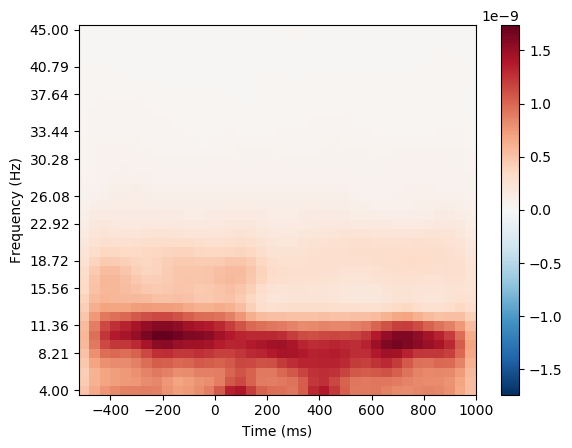

In [96]:
tfr.plot([0])

Widzimy w wykresie powyżej niewiele, (w niektórych plikach widać, że coś dzieje się w okolicy 10 Hz przed prezentacją bodźca i znika wraz z pojawieniem się wskazówki, albo że pojawia się w niższych częstotliwościach po prezentacji bodźca). Potrzebujemy zastosować baseline'owanie. Przetestujmy najpierw baseline typu `'percent'` który zamienia nam wartości mocy na % zmiany względem okresu baseline'u. W naszym wypadku okres baseline'u to czas sprzed prezentacji bodźca - ale ustawimy go na -0.4 do -0.2 s (ponieważ analizy czas częstośc nie są punktowe wynik dla okolic 0 s faktycznie pochodzi z okna czasowego wokół tego punktu, dlatego nie chcemy brać baseline'u zbyt blisko zera - bo baseline będzie nam się mieszał z czasem po zaprezentowaniu bodźca):

Applying baseline correction (mode: percent)


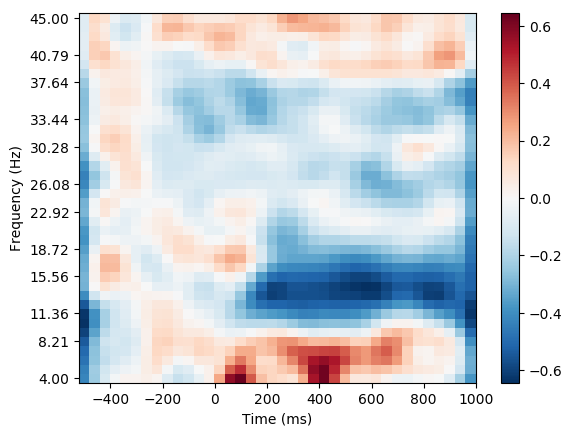

In [97]:
tfr.plot([0], baseline=(-0.4, -0.15), mode='percent')

Applying baseline correction (mode: zscore)
Applying baseline correction (mode: mean)


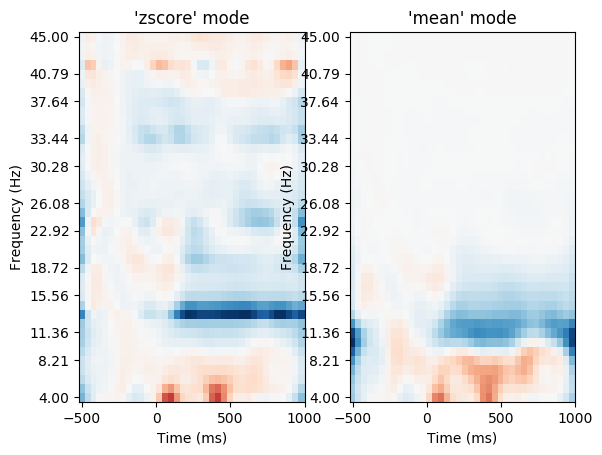

In [98]:
# porównajmy tryb 'zscore' z trybem 'mean':
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2)

tfr.plot([0], baseline=(-0.4, -0.15), mode='zscore', axes=ax[0],
         show=False, colorbar=False)
ax[0].set_title("'zscore' mode")
ax[1].set_title("'mean' mode")
tfr.plot([0], baseline=(-0.4, -0.15), mode='mean', axes=ax[1],
        colorbar=False)

In [99]:
# ok, zerknijmy teraz na cały łepek - do tego musimy policzyć time-freq dla wszystkich elektrod
# to portrwa zdecydowanie dłużej (bo liczymy czas-częstość dla każdej z wielu elektrod)
tfr = tfr_morlet(epochs, freq, n_cycles, return_itc=False,
                 use_fft=True, decim=10)

Applying baseline correction (mode: percent)


C:\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


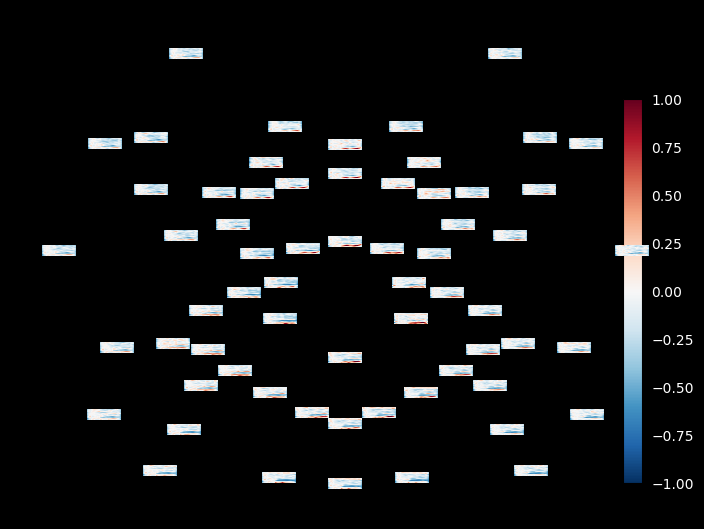

c:\proj\src\mne-python\mne\viz\topo.py:220: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(face_color)


In [100]:
# zobaczmy teraz jak wygląda czas-częstość na łebku:
tfr.plot_topo(baseline=(-0.4, -0.15), mode='percent', vmin=-1, vmax=1)

Applying baseline correction (mode: percent)


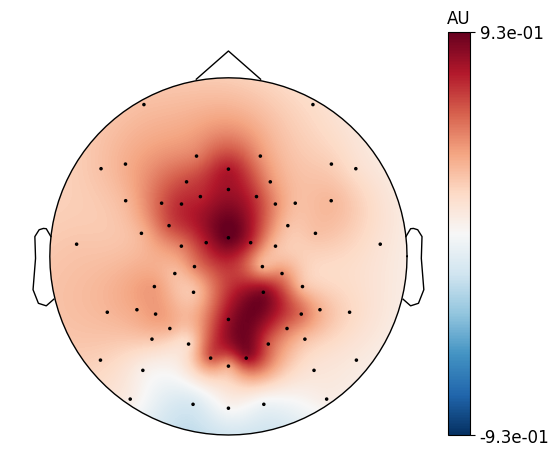

In [101]:
tfr.plot_topomap(tmin=0.6, tmax=0.8, fmin=8., fmax=12,
                 baseline=(-0.4, -0.15), mode='percent')

In [103]:
# ale uwaga, nie mamy wszystkich plików dla tej osoby, każda osobato dwa pliki
print(this_file)
current_subject_files = [f for f in set_files if this_file[:3] in f]
print(current_subject_files)

D18_1.set
['D18_1.set', 'D18_2.set']


In [104]:
# jeżeli chcielibyście brać pod uwagę, to że
# każda osoba to dwa pliki możecie robić tak:
epoch_list = list()
event_list = list()

for f in current_subject_files:
    epochs = read_epochs_eeglab(op.join(data_dir, f), verbose=False)
    events = read_set_events(op.join(data_dir, f), ignore_fields=['urevent'])
    
    epoch_list.append(epochs)
    event_list.append(events.query('cue == 1'))

In [106]:
# teraz korzystamy z metody do łączenia epok
epochs = mne.concatenate_epochs(epoch_list)


# oraz z metody do łączenia dataframes:
import pandas as pd
events = pd.concat(event_list)

print(len(epochs) == events.shape[0])

217 matching events found
True


Teraz możemy policzyć czas częstość w trochę inny sposób. Tym razem weźmiemy sobie 35 logarytmicznie rosnących częstotliwości od 3 do 80 Hz. 3 Hz to bardzo niska częstotliwość - w 0.5 sekundy (a tyle mamy w baselinie) mieści się jej 1.5 cyklu. Aby się zmieścić z taką częstotliwością w baselinie ustawimy sobie ilość cykli na okienko analizy 1 dla najniższej częstotliwości i rośnie liniowo do 30.

In [113]:
# definiujemy krańce częstotliwości w logarytmicznej przestrzeni
freq_lims = np.log10([3, 80])
freqs = np.logspace(*freq_lims, num=35) # * rozpakowuje nam listę w poszczególne argumenty
n_cycles = np.logspace(*np.log10([1, 45]), num=35)

# zobaczmy sobie freqs i cycles dla kilku pierwszych częstotliwości
print(freqs[:10])
print(n_cycles[:10])

[ 3.          3.30416336  3.63916518  4.00813209  4.41450773  4.86208491
  5.35504094  5.8979767   6.49595951  7.15457048]
[ 1.          1.11846886  1.25097259  1.39917389  1.56493243  1.75032819
  1.95768758  2.18961259  2.4490135   2.73914534]


In [114]:
# policzmy jak długie jest okno analizy dla każdej częstotliwości
n_cycles / freqs

array([ 0.33333333,  0.33850289,  0.34375263,  0.34908378,  0.35449761,
        0.3599954 ,  0.36557845,  0.37124809,  0.37700566,  0.38285252,
        0.38879006,  0.39481968,  0.40094281,  0.40716091,  0.41347544,
        0.4198879 ,  0.4263998 ,  0.4330127 ,  0.43972816,  0.44654776,
        0.45347313,  0.4605059 ,  0.46764774,  0.47490034,  0.48226542,
        0.48974472,  0.49734001,  0.5050531 ,  0.51288581,  0.52083999,
        0.52891753,  0.53712035,  0.54545038,  0.55390959,  0.5625    ])

In [116]:
tfr = tfr_morlet(epochs, freqs, n_cycles, return_itc=False, use_fft=True)

Applying baseline correction (mode: percent)


C:\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


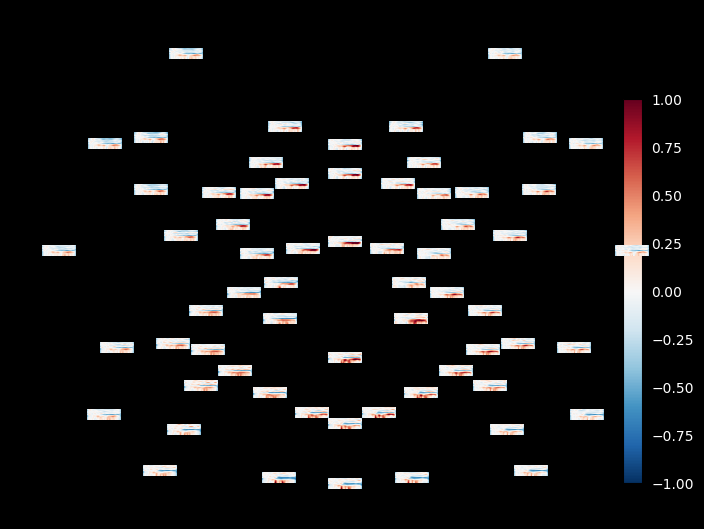

c:\proj\src\mne-python\mne\viz\topo.py:220: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor(face_color)


In [117]:
tfr.plot_topo(baseline=(-0.4, -0.15), mode='percent', vmin=-1, vmax=1)

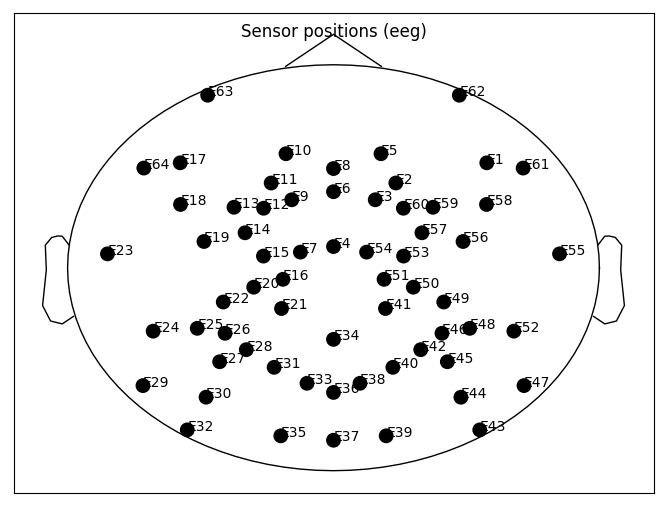

In [118]:
epochs.plot_sensors(show_names=True)

Applying baseline correction (mode: percent)


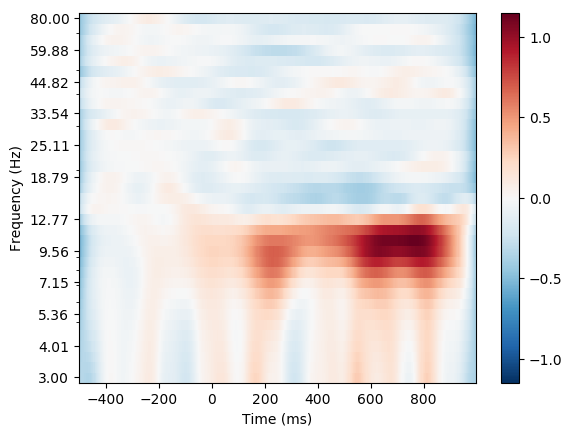

In [119]:
# UWAGA! jeżeli NIE korzystacie z deweloperskiej wersji mne 
# (albo wersji 0.14, która powinna wyjść na dniach) to
# wykres poniżej będzie miał złe oznaczenia częstotliwości
# naprawiliśmy to dopiero niedawno
tfr.plot([epochs.ch_names.index('E8')], baseline=(-0.4, -0.15), mode='percent')

0.14.dev0
Applying baseline correction (mode: percent)


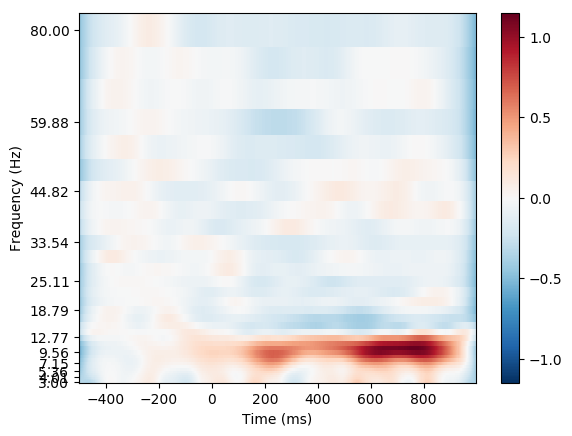

In [120]:

# jeżeli nie chcecie logarytmicznej skali możecie skorzystać z 
# argumentu yscale, który dodałem, naprawiając wyświetlanie logarytmiczne
# to zadziała tylko na wersji deweloperskiej albo 0.14
print(mne.__version__)

tfr.plot([epochs.ch_names.index('E8')], baseline=(-0.4, -0.15),
         mode='percent', yscale='linear')

oznaczenia na osi x nie wyglądają teraz ładnie - to będę musiał jeszcze poprawić :)
widzimy w każdym razie różnicę między częstotliwościami jakie mamy teraz a tymi 
wcześniej - logarytmiczne częstotliwości stosuje się dosyć często aby z większą
dokładnością pokazywać niskie częstotliwości a z mniejszą wysokie (zmiany w wysokich
częstotliwościach są często bardziej "rozlane" - objemują wiele Hz).

Przejdźmy teraz do porównania warunków. Wybierzemy sobie oddzielnie epoki, w których
wskazówka była różnicująca oraz te, w których nie była różnicująca i zrobimy dla nich
tfr (*time-frequency representation*):

In [123]:
# sprawdzamy gdzie events.dyscr (kolumna dyscr tabeli events)
# wynosi 1 (tzn. wskazówka jest dyskryminująca)
if_dyscrim = events.dyscr == 1

print('mamy', sum(if_dyscrim), 'wydarzeń dyskryminujących')
print('mamy', sum(~if_dyscrim), 'wydarzeń niedyskryminujących')

mamy 148 wydarzeń dyskryminujących
mamy 69 wydarzeń niedyskryminujących


Widzimy, że jest spora dysproporcja w liczbie wydarzeń. Poprawnie byłoby wyrównać ilość wydarzeń między warunkami, losując z wydarzeń, których jest więcej tylko tyle aby było ich tyle samo, co 
wydarzeń, których jest mniej. To jest o tyle istotne, że oszacowania mocy (w TFR) czy nawet amplitudy sygnału (w ERP) są zależne od ilości powtórzeń - im więcej powtórzeń tym mniejszy jest wkład zmienności sygnału niezwiązanej z bodźcem tzn. mniejszy szum. Na razie nie będziemy się tym jednak przejmować aby niekomplikować sprawy zbytnio (i tak ten notebook jest już wystarczająco skomplikowany).

In [124]:
freq = np.arange(4, 61) # działa tak jak range, ale daje nam array tzn. w tym wypadku wektor
n_cycles = freq / 4 # częstotliwość dzielona na 4 czyli 0.25 s

In [126]:
tfrs = dict()
chan_ind = epochs.ch_names.index('E6')

tfrs['dysc'] = tfr_morlet(epochs[if_dyscrim], freq, n_cycles, picks=[chan_ind],
                          return_itc=False, use_fft=True, decim=10)
tfrs['nondysc'] = tfr_morlet(epochs[~if_dyscrim], freq, n_cycles, picks=[chan_ind],
                          return_itc=False, use_fft=True, decim=10)

In [127]:
# tym razem użyjemy metody `apply_baseline` aby nie musieć cały czas
# definiować baseline'u przy plotowaniu
# korzystamy tu z pętli po kluczach słownika - sprawdź sobie, co daje
# Ci list(tfrs.keys())
for k in tfrs.keys():
    tfrs[k].apply_baseline((-0.4, -0.15), mode='percent')

Applying baseline correction (mode: percent)
Applying baseline correction (mode: percent)


No baseline correction applied
No baseline correction applied


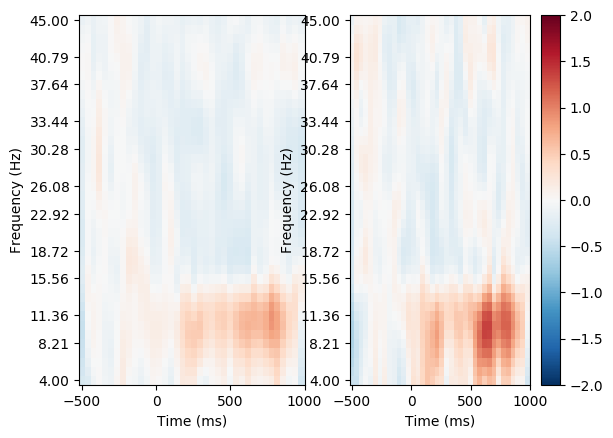

In [129]:
fig, axes = plt.subplots(ncols=2)

tfrs['dysc'].plot([0], show=False, colorbar=False, vmin=-2, vmax=2, axes=axes[0])
tfrs['nondysc'].plot([0], vmin=-2, vmax=2, axes=axes[1])

Różnica, którą widzimy powyżej może nie być istotna, ale niewykluczene, że wynika właśnie z ilości triali. Aby zrobić prównanie statystyczne musielibyśmy je zrobić na poziomie pojedynczych powtórzeń
(powyższe wykresy pochodzą z jednej osoby - są średnią z powtórzeń, a nie średnią z osób), a nie uśrednionych odpowiedzi, tzn. przy `tfr_morlet` musielibyśmy ustawić argument `average=False`.

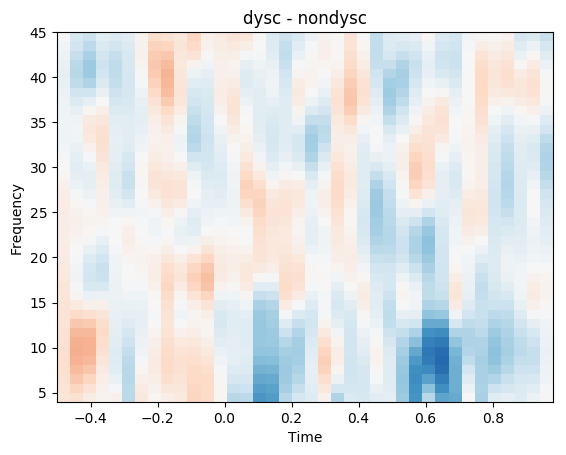

In [136]:
data_diff = tfrs['dysc'].data[0, :] - tfrs['nondysc'].data[0, :]

# korzystamy ze zwykłego matplotlibowego imshow, ale korzystamy z
# różnych dodatkowych argumentów aby wynik był podobny do tfr.plot()
im = plt.imshow(data_diff, vmin=-1, vmax=1, origin='lower', cmap='RdBu_r',
           extent=[*tfrs['dysc'].times[[0, -1]], *tfrs['dysc'].freqs[[0, -1]]],
           aspect='auto')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('dysc - nondysc')
im.figure

## Jak zrobić analizę grupową
na razie podpowiedź:
* dla każdej osoby zrobić tfr dla dysc i nondysc
  (chyba że chcemy inny kontrast np. pierwsza vs druga wskazówka)
  dla interesującej nas elektrody
* z każdego tfr wyciągamy dane tak:
  ```python
  tfr_data = tfr.data[0, :]
  ```
  `[0, :]` - oznacza: pierwsza elektroda a cała reszta jak leci (`:`) tzn. wszystkie częstotliwości i cały czas
* mamy listę `dysc_tfrs` oraz `nondysc_tfrs`, do których doklejamy `tfr_data` dla adekwatnych warunków z poszczególnych osób:
  ```python
  # zakładamy, że tfr_data mamy z tfr dla warunku dysc
  dysc_tfrs.append(tfr_data)
  ```
* po pętli przez wszystkie osoby (uwaga na powtarzające się pliki - tzn. każda osoba ma po dwa pliki zwykle) używamy `np.stack` aby skleić w jedną macierz dane z listy `dysc_tfrs` oraz oddzielnie listy `nondysc_tfrs`. W ten sposób zamiast listy `dysc_tfrs` staje się macierzą o wymiarach `osoby x częstotliwości x czas`:
  ```python
  dysc_tfrs = np.stack(dysc_tfrs, axis=0)
  nondysc_tfrs = np.stack(nondysc_tfrs, axis=0)
  ```
* teraz możemy wykonać kontrast testem t - tak samo jak w notebooku z zajęć 5 w sekcji wielokrotne porównania

(jeżeli ktoś chciałby zrobić cluster-based permutation test dla jednej albo większej liczby elektrod - dajcie znać, pomogę, obecnie funkcje do tego testu są dosyć toporne)